In [1]:
import numpy as np
import pandas as pd
import csv
import struct
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import statistics as sts

In [2]:
# reading and additional functions

# define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

# check exist date in roti date array
def exist_date_roti(roti_date, date_check):
    for date_r in roti_date:
        if date_check[0] == date_r[0] and date_check[1] == date_r[1] and date_check[2] == date_r[2]:
            return True
    return False

# convert doy in normal date with day and month
def doy2day(doy, year):
    startDate = datetime(year=year, month=1, day=1)
    daysToShift = doy - 1
    endDate = startDate + timedelta(days=daysToShift)
    
    month = endDate.month
    day = endDate.day
    
    return day, month

def read_roti(filename):
    with open(filename, 'rb') as f:
        header_read = False
        date = None
        lats = []
        rows = []
        date_arr = []
        line = f.readline()
        while not header_read or (line.strip() and not line.strip().startswith(b"END OF ROTIPOLARMAP")):
            if line.strip().startswith(b"START OF ROTIPOLARMAP"):
                header_read = True
            elif line.strip().startswith(b"END OF ROTIPOLARMAP") or line.strip().startswith(b"END OF FILE"):
                break
            elif not header_read:
                pass
            elif line[0:5].strip():
                date = datetime(int(line[0:7]), int(line[7:14]), int(line[14:21]))
                year = int(line[0:7])
                month = int(line[7:14])
                day = int(line[14:21])
                
                date_arr.append(day)
                date_arr.append(month)
                date_arr.append(year)
            else:
                lat, lon_start, lon_end = float(line[3:9]), float(line[9:15]), float(line[15:21])
                lats.append(lat)

                block = [f.readline() for _ in range(18)]
                row = np.genfromtxt(block)
                rows.append(row.ravel())
            line = f.readline()
        return date, np.array(lats), np.array(date_arr), np.array(rows)

def get_array_roti():
    maps = []
    map_date = []
    for year in range(10, 19, 1):
        for doy in range(1, 367, 1):
            if doy >= 91 and year == 19:
                break
            daily_lats = []
            daily_date = []
            daily_map = []
            
            if len(str(doy)) == 1:
                doy_str = "00" + str(doy)
            elif len(str(doy)) == 2:
                doy_str = "0" + str(doy)
            else:
                doy_str = str(doy)
            filename = '../data/roti/2010-2020/roti' + doy_str + '0.' + str(year) + 'f'
            try:
                date, daily_lats, daily_date, daily_map = read_roti(filename)
            except FileNotFoundError:
                continue
            else:
                date, daily_lats, daily_date, daily_map = read_roti(filename)

            map_date.append(daily_date)
            maps.append(daily_map)

    return np.array(map_date), np.array(maps)

def read_dst(filename, roti_date):
    with open(filename, 'r') as f:
        dst_arr = []
        dst_mean_arr = []
        dst_date = []

        day = 0
        month = 0
        year = 0

        while day != 21 or month != 10 or year != 2020:
            dst_daily = []
            date = []

            line = f.readline()

            year = int(2000 + int(line[3:5]))
            month = int(line[5:7])
            day = int(line[8:10])
                
            date.append(day)
            date.append(month)
            date.append(year)
            
            if not exist_date_roti(roti_date, date):
                continue

            dst_date.append(date)

            if len(line) > 121:
                index_string = line[21:len(line)]
            else:
                index_string = line[21:120]

            index_value = index_string.split()
            for value in index_value:
                val = float(value)
                dst_daily.append(val)

            dst_mean = dst_daily[-1]
            dst_daily.pop(-1)
            dst_arr.append(dst_daily)
            dst_mean_arr.append(dst_mean)
        
        return np.array(dst_arr), np.array(dst_date), np.array(dst_mean_arr)

def add_special_date_f107(day, month, year, f107_arr, f107_date):
    f107_daily = []
    date = []
    if year == 2011:
        value = 90.1
    elif year == 2012:
        value = 131.75
    elif year == 2015:
        value = 148.8
    elif year == 2020:
        value = 72.93
    f107_daily.append(value)
    f107_arr.append(f107_daily)
    date.append(day)
    date.append(month)
    date.append(year)
    f107_date.append(date)
    return f107_arr, f107_date

def read_f107(filename, roti_date):
    with open(filename, 'rb') as f:
        f107_arr = []
        f107_date = []
        day = 0
        month = 0
        year = 0
        
        # we should skip 2 lines in file bc it is head of file
        line = f.readline()
        line = f.readline()

        start_indx = 0
        sum_siblings = 0
        f107_obs_sum = 0

        while day != 22 or month != 10 or year != 2020:
            f107_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])
            
            if year < 2009 or month < 12 or day < 4:
                continue
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            if start_indx == 0:
                start_date = date
                start_indx = 1

            f107_obs = float(line[53:63])

            if start_date[0] != date[0] or start_date[1] != date[1] or start_date[2] != date[2]:
                f107_date.append(start_date)
                if sum_siblings == 1:
                    value = f107_obs_sum / 2
                elif sum_siblings == 2:
                    value = f107_obs_sum / 3
                elif sum_siblings == 3:
                    value = f107_obs_sum / 4
                else:
                    value = f107_obs
                f107_daily.append(value)
                f107_arr.append(f107_daily)
                sum_siblings = 0
                f107_obs_sum = 0
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2010:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2011, f107_arr, f107_date)
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2011:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2012, f107_arr, f107_date)
                if start_date[0] == 12 and start_date[1] == 1 and start_date[2] == 2015:
                    f107_arr, f107_date = add_special_date_f107(13, 1, 2015, f107_arr, f107_date)
                if start_date[0] == 20 and start_date[1] == 10 and start_date[2] == 2020:
                    f107_arr, f107_date = add_special_date_f107(21, 10, 2020, f107_arr, f107_date)
                start_date = date
            else:
                f107_obs_sum += f107_obs
                sum_siblings += 1

        return np.array(f107_arr), np.array(f107_date)

def read_bz_sw(filename, roti_date):
    with open(filename, 'rb') as f:
        bz_arr = []
        bz_date = []
        sw_arr = []
        sw_date = []
        
        day = 0
        month = 0
        year = 0
        
        while day != 21 or month != 10 or year != 2020:
            bz_daily = []
            sw_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue
            
            bz_sw_string = line[18:len(line)]
            bz_sw_value = bz_sw_string.split()
            
            bz_date.append(date)
            sw_date.append(date)
            
            for i in range(3):
                if i == 0:
                    bz_daily.append(float(bz_sw_value[i].decode()))
                else:
                    sw_daily.append(float(bz_sw_value[i].decode()))
            
            bz_arr.append(bz_daily)
            sw_arr.append(sw_daily)
        
    return np.array(bz_arr), np.array(bz_date), np.array(sw_arr), np.array(sw_date)

def read_kp(filename, roti_date):
    with open(filename, 'rb') as f:
        kp_arr = []
        kp_date = []
        
        day = 0
        month = 0
        year = 0

        # we should skip first line in file bc it is head of file
        line = f.readline()
        
        while day != 21 or month != 10 or year != 2020:
            kp_daily = []
            date = []

            line = f.readline()

            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])

            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            kp_date.append(date)

            kp_str = str(line[25:28].decode())
            
            if kp_str[len(kp_str) - 1] == '+':
                kp_value = float(kp_str[:len(kp_str) - 1]) + 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            elif kp_str[len(kp_str) - 1] == '-':
                kp_value = float(kp_str[:len(kp_str) - 1]) - 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            else:
                kp_value = float(kp_str)

            kp_daily.append(kp_value)
            kp_arr.append(kp_daily)
            
        return np.array(kp_arr), np.array(kp_date)


- scalar B (IMF) - average 24 hour (1 value)    
- BZ - average 24 hour (1 value)    
- BZ - min 24 hour (1 value)    
- F10-7 - average 24 hour (1 value)     
- F10-7 - 27-days (27 previous days) median (1 value)
- AL - average 24 hour (1 value)    
- AU - average 24 hour (1 value)    
- date (1 value)    

index | name
:----: | ------------
0 | avg scalar B
1 | avg BZ
2 | avg F10-7
3 | avg AL
4 | avg AU
5 | min BZ
6 | F10-7 27-days median
7-12 | indexes 0-5 27 days ago

In [3]:
# read data function

def read_all_data(filename, roti_date):
    with open(filename, 'rb') as f:
        all_data_arr = []
        date_arr = []
        
        day = 0
        month = 0
        year = 0
        
        while day != 1 or month != 4 or year != 2019:
            all_data_daily = []
            data_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date) and year >= 2010:
                continue
            
            for _ in range(23):
                all_data_hour = []
                data_string = line[13:len(line)]
                data_values = data_string.split()
                for i in range(5):
                    all_data_hour.append(float(data_values[i].decode()))
                all_data_daily.append(all_data_hour)
                line = f.readline()

            all_data_daily = np.array(all_data_daily)
            data_min = all_data_daily.min(axis=0)
            data_means = np.mean(all_data_daily, axis=0)
            # add average values
            for i in range(len(data_means)):
                data_daily.append(data_means[i])
            # add min bz
            data_daily.append(data_min[1])
            all_data_arr.append(data_daily)
            date_arr.append(date)

    return np.array(all_data_arr), np.array(date_arr)

def median_f107(all_data, start_indx):
    all_median = []

    for index in range(start_indx, len(all_data), 1):
        median = []
        for i in range(index - 26, index + 1, 1):
            median.append(all_data[i][2])
        median = sorted(median)
        all_median.append(median[14])
    return np.array(all_median)
    

def get_all_data(filename, roti_map_date):
    all_data, date_arr = read_all_data(filename, roti_map_date)
    data_all_arr = []
    all_date_arr = []

    start_indx = 0
    for i in range(len(date_arr)):
        if date_arr[i][0] == 1 and date_arr[i][1] == 1 and date_arr[i][2] == 2010:
            start_indx = i
            break
    f107_median = median_f107(all_data, start_indx)
    
    for i in range(start_indx, len(all_data), 1):
        data_daily = []
        for j in range(6):
            data_daily.append(all_data[i][j])
        data_daily.append(f107_median[i - 31])
        for j in range(6):
            data_daily.append(all_data[i - 26][j])
        all_date_arr.append(date_arr[i])
        data_all_arr.append(data_daily)

    return np.array(data_all_arr), np.array(all_date_arr)


In [25]:
# plotting functions

def plot_data_roti(date, lons, lats, map):
    lons, lats = np.meshgrid(lons, lats)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='polar')
    levels = np.arange(0, 0.6, 0.1)
    cc = ax.contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')

    plt.title("ROTI index date: " + str(date))

    plt.colorbar(cc, ax=ax, label="ROTI, TECU/min")

    mlt = np.linspace(0, 24, 49)

    plt.show()

def plot_sw_index(date, array_data, name_index):
    fig_prot = plt.figure()
    ax_prot = fig_prot.add_subplot(111)

    fig_pls = plt.figure()
    ax_pls = fig_pls.add_subplot(111)

    prot = []
    pls = []

    data_month_prot = []
    data_month_pls = []
    month_line_prot = []
    month_line_pls = []

    if name_index == 'Solar Wind':
        for item in array_data:
            prot.append(item[0])
            pls.append(item[1])

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month_prot.append(np.mean(prot[i - 30: i]))
            data_month_pls.append(np.mean(pls[i - 30: i]))
            month_line_prot.append(i - 30 / 2)
            month_line_pls.append(i - 30 / 2)

    data_avg_prot = moving_avg(prot, 400)
    data_avg_plasm = moving_avg(pls, 400)
    data_avg_prot.reshape(len(data_avg_prot), 1)
    data_avg_plasm.reshape(len(data_avg_plasm), 1)
    step = len(prot) / len(data_avg_prot)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg_prot), 1)

    ax_pls.set_title('Data index Plasma Speed, km/s')
    ax_pls.set_xlabel('Days', size=12)
    ax_pls.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_pls.plot(month_line_pls, data_month_pls, label='Month')
    ax_pls.plot(day_avg, data_avg_plasm, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_pls.legend(loc='upper left')

    ax_prot.set_title('Data index Proton Density, N/cm^3')
    ax_prot.set_ylim(0, 20)
    ax_prot.set_xlabel('Days', size=12)
    ax_prot.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_prot.plot(month_line_prot, data_month_prot, label='Month')
    ax_prot.plot(day_avg, data_avg_prot, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_prot.legend(loc='upper left')

    plt.show()

def plot_data_index(date, array_data, name_index):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    data_month = []
    month_line = []

    data_half_year = []
    half_year_line = []

    data_year = []
    year_line = []

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month.append(np.mean(array_data[i - 30: i]))
            month_line.append(i - 30 / 2)

    for i in range(len(array_data)):
        if i % 180 == 0:
            data_half_year.append(np.mean(array_data[i - 180: i]))
            half_year_line.append(i - 180 / 2)
    
    data_avg = moving_avg(array_data, 400)
    data_avg.reshape(len(data_avg), 1)
    step = len(array_data) / len(data_avg)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg), 1)

    ax.set_title('Data index ' + name_index)
    ax.set_xlabel('Days', size=12)
    ax.set_ylabel(name_index, size=12)

    match name_index:
        case 'Flux 10-7':
            ax.plot(month_line, data_month, label='Month')
            ax.plot(half_year_line, data_half_year, label='Half-year')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(year_line, data_year, color='black', label='Year')
            ax.legend(loc='upper left')
        case 'Imf-Bz':
            # ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
        case _:
            ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
    plt.show()

def plot_new_data_index(date, data, name_index, index):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    data_month = []
    month_line = []

    data_half_year = []
    half_year_line = []

    data_year = []
    year_line = []

    array_data = []

    for i in range(len(data)):
        array_data.append(data[i][index])
    array_data = np.array(array_data)

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month.append(np.mean(array_data[i - 30: i]))
            month_line.append(i - 30 / 2)

    for i in range(len(array_data)):
        if i % 180 == 0:
            data_half_year.append(np.mean(array_data[i - 180: i]))
            half_year_line.append(i - 180 / 2)
    
    data_avg = moving_avg(array_data, 400)
    data_avg.reshape(len(data_avg), 1)
    step = len(array_data) / len(data_avg)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg), 1)

    ax.set_title('Data index ' + name_index)
    ax.set_xlabel('Days', size=12)
    ax.set_ylabel(name_index, size=12)

    match name_index:
        case 'average BZ':
            ax.set_ylim(-0.2, 0.3)
            ax.plot(month_line, data_month, label='Month')
            ax.plot(half_year_line, data_half_year, label='Half-year')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(year_line, data_year, color='black', label='Year')
            ax.legend(loc='upper left')
        case 'average F10-7':
            # ax.set_ylim(0, 60)
            # ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            ax.plot(half_year_line, data_half_year, color='orange', label='Half-year')
            ax.legend(loc='upper left')
        case 'median F10-7':
            # ax.set_ylim(0, 60)
            ax.plot(day_line, array_data, label='Day')
            # ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='orange', label='Half-year')
            ax.legend(loc='upper left')
        case _:
            ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
    plt.show()

In [5]:
# roti data and date
roti_map_date = []
roti_maps = []
roti_map_date, roti_maps = get_array_roti()

# filename = "../data/roti/rt_data_10-20.txt"
# date, lats, roti_map_date, roti_maps = read_roti_txt(filename)

In [14]:
filename = "../data/imf-bz-f107-au-al/omni2_1C8cy8n9vH.lst.txt"
data_all_arr, date_arr = get_all_data(filename, roti_map_date)
print(data_all_arr.shape)
print(date_arr.shape)

(3277, 13)
(3277, 3)


index | name
:----: | ------------
0 | avg scalar B
1 | avg BZ
2 | avg F10-7
3 | avg AL
4 | avg AU
5 | min BZ
6 | F10-7 27-days median
7-12 | indexes 0-5 27 days ago

### Principal Component Analysis (PCA)

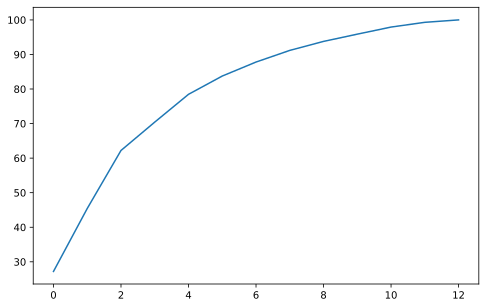

In [17]:
# Normalize data
train_num = len(data_all_arr)

def mean_data(data):
    mean = data[:train_num].mean(axis=0)
    data -= mean
    std = data[:train_num].std(axis=0)
    data /= std
    return data

all_indexes = mean_data(data_all_arr)

from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_features = scaler.fit_transform(all_indexes)

pca = PCA(n_components=13)
pca.fit(X_features)
pca_variance = pca.explained_variance_

var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.figure(figsize=(8, 5))
plt.plot(var1)
plt.show()

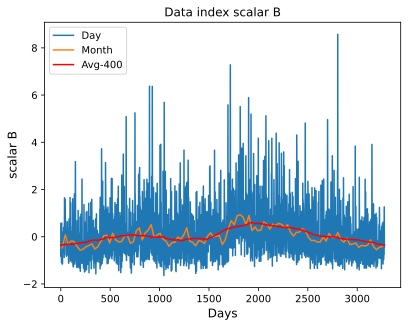

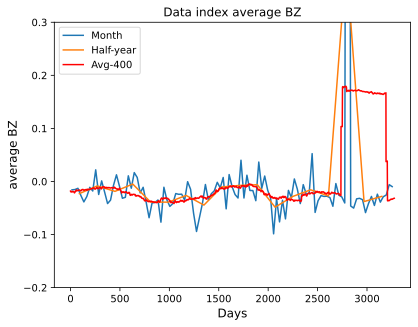

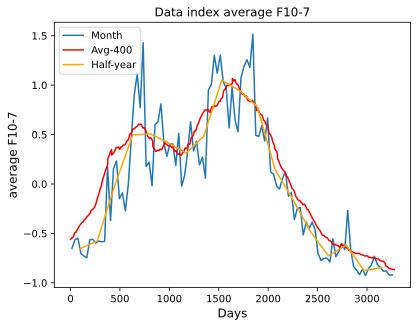

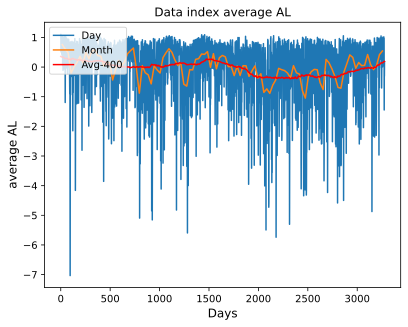

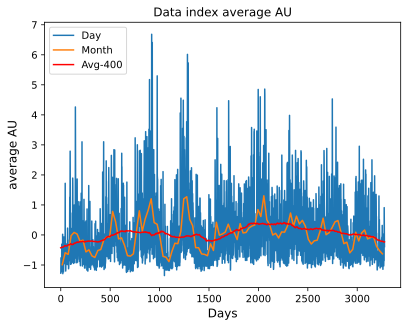

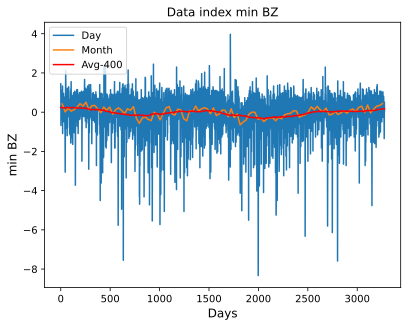

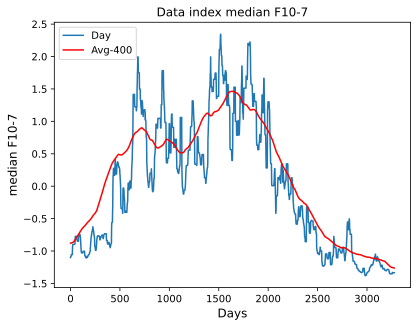

In [26]:
plot_new_data_index(date_arr, data_all_arr, 'scalar B', 0)
plot_new_data_index(date_arr, data_all_arr, 'average BZ', 1)
plot_new_data_index(date_arr, data_all_arr, 'average F10-7', 2)
plot_new_data_index(date_arr, data_all_arr, 'average AL', 3)
plot_new_data_index(date_arr, data_all_arr, 'average AU', 4)
plot_new_data_index(date_arr, data_all_arr, 'min BZ', 5)
plot_new_data_index(date_arr, data_all_arr, 'median F10-7', 6)

In [56]:
# data
# kp_data, bz_data, sw_data, f107_data, dst_data

# kp_file = '../data/kp/Kp_index.txt'
# kp_arr, kp_date = read_kp(kp_file, roti_map_date)

# bz_sw_file = '../data/imfbz_sw/omni2_daily_Wxi8tQda3U.lst.txt'
# bz_arr, bz_date, sw_arr, sw_date = read_bz_sw(bz_sw_file, roti_map_date)

# f107_file = '../data/f10-7/fluxtable.txt'
# f107_arr, f107_date = read_f107(f107_file, roti_map_date)

# dst_file = '../data/dst/WWW_dstae03359771.dat.txt'
# dst_arr, dst_date, dst_mean_arr = read_dst(dst_file, roti_map_date)

In [27]:
# shape of data
# print("shape kp data ", kp_arr.shape)
# print("shape kp date line ", kp_date.shape)
# print("shape bz data ", bz_arr.shape)
# print("shape bz date line ", bz_date.shape)
# print("shape sw data ", sw_arr.shape)
# print("shape sw date line ", sw_date.shape, "\n")
# print("shape f10-7 data ", f107_arr.shape)
# print("shape f10-7 date line ", f107_date.shape, "\n")
# print("shape dst data ", dst_arr.shape)
# print("shape dst data mean", dst_mean_arr.shape)
# print("shape dst date line ", dst_date.shape, "\n")
roti_maps_reshape = roti_maps.reshape(3277, 3600)
print("shape roti data ", roti_maps.shape)
print("shape roti data reshape", roti_maps_reshape.shape)
print("shape roti date line ", roti_map_date.shape)

shape roti data  (3277, 20, 180)
shape roti data reshape (3277, 3600)
shape roti date line  (3277, 3)


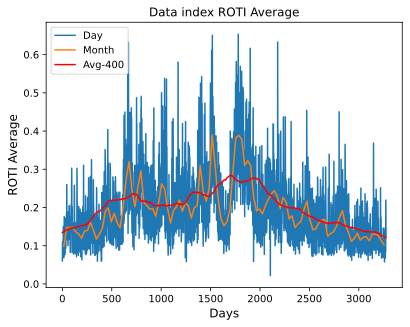

In [28]:
def plot_roti_graph(roti_maps_reshape, roti_map_date):
    average_roti = []
    for i in range(len(roti_maps_reshape)):
        avg = sts.mean(roti_maps_reshape[i])
        average_roti.append(avg)

    average_roti = np.array(average_roti)
    plot_data_index(roti_map_date, average_roti, 'ROTI Average')

plot_roti_graph(roti_maps_reshape, roti_map_date)

In [72]:
def average_roti_classification(roti_maps_reshape):
    # data roti
    roti_class = []
    # data dst
    for i in range(len(roti_maps_reshape)):
        roti_class.append(sts.mean(roti_maps_reshape[i]))
    avr_num = sts.mean(roti_class)
    less_count = 0
    more_count = 0
    roti_class = np.array(roti_class)
    for i in range(len(roti_maps_reshape)):
        if roti_class[i] <= avr_num:
            less_count += 1
        else:
            more_count += 1
    delta = less_count - more_count
    percent = delta / less_count * 100
    return avr_num, less_count, more_count, delta, percent

def data_make_roti_classification(roti_maps_reshape, all_indexes):
    avr_num, less_count, more_count, delta, percent = average_roti_classification(roti_maps_reshape)
    print("average ROTI", avr_num)
    roti_class = []
    for i in range(len(roti_maps_reshape)):
        if sts.mean(roti_maps_reshape[i]) < avr_num:
            roti_class.append(0)
        else:
            roti_class.append(1)
    return np.array(roti_class)
    
# print(average_roti_classification(roti_maps_reshape))
roti_class = data_make_roti_classification(roti_maps_reshape, all_indexes)

average ROTI 0.19258764722137456


In [104]:
from keras.optimizers import RMSprop, Adam
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=3000,
    decay_rate=0.95)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_indexes, roti_class, test_size=0.1)

from keras import Sequential
from keras.layers import Dense
classifier = Sequential()
classifier.add(Dense(18, activation='relu', kernel_initializer='random_normal', input_dim=13))
classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(9, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

classifier.compile(optimizer =Adam(learning_rate=lr_schedule),loss='binary_crossentropy', metrics =['accuracy'])

history = classifier.fit(X_train, y_train, batch_size=24, epochs=150)

eval_model=classifier.evaluate(X_train, y_train)

Epoch 1/150
123/123 [==============================] - 0s 571us/step - loss: 0.6164 - accuracy: 0.7328
Epoch 2/150
123/123 [==============================] - 0s 556us/step - loss: 0.3230 - accuracy: 0.8603
Epoch 3/150
123/123 [==============================] - 0s 553us/step - loss: 0.2967 - accuracy: 0.8667
Epoch 4/150
123/123 [==============================] - 0s 571us/step - loss: 0.2836 - accuracy: 0.8739
Epoch 5/150
123/123 [==============================] - 0s 581us/step - loss: 0.2764 - accuracy: 0.8752
Epoch 6/150
123/123 [==============================] - 0s 579us/step - loss: 0.2708 - accuracy: 0.8810
Epoch 7/150
123/123 [==============================] - 0s 572us/step - loss: 0.2666 - accuracy: 0.8803
Epoch 8/150
123/123 [==============================] - 0s 561us/step - loss: 0.2634 - accuracy: 0.8834
Epoch 9/150
123/123 [==============================] - 0s 556us/step - loss: 0.2603 - accuracy: 0.8874
Epoch 10/150
123/123 [==============================] - 0s 558us/step - l

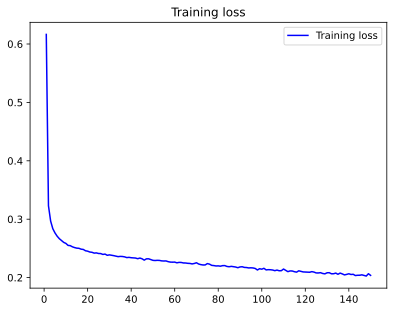

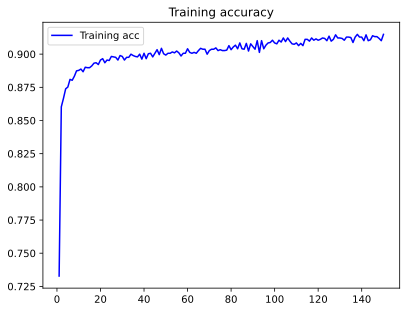

[0.19940580427646637, 0.9142082333564758]


In [105]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
# plt.ylim(0, 0.3)
plt.legend()
plt.show()

acc = history.history['accuracy']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.show()

print(eval_model)

In [106]:
from sklearn.metrics import accuracy_score
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)

print(accuracy_score(y_test, y_pred))

11/11 [==============================] - 0s 558us/step
0.9085365853658537


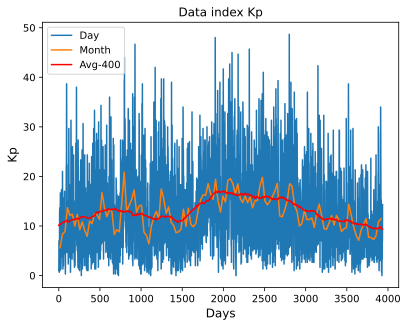

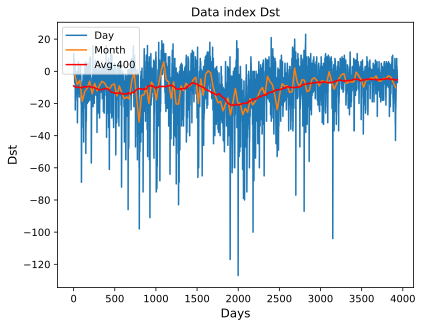

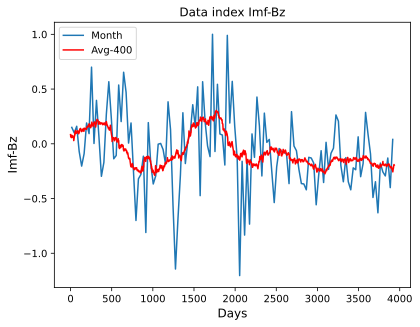

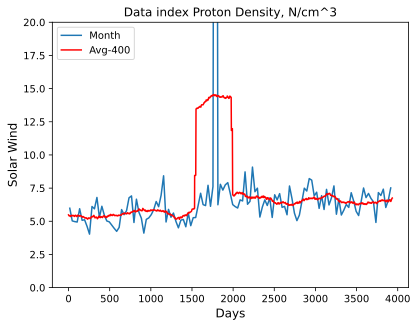

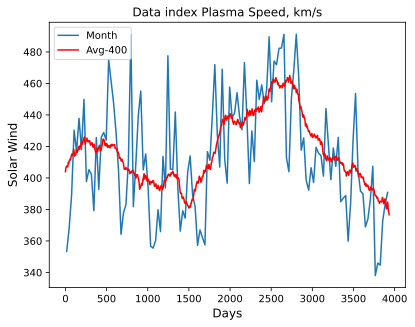

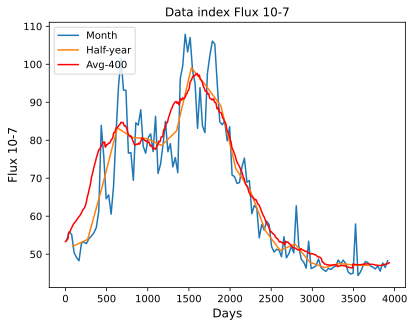

In [8]:
# analyze graphs

plot_data_index(kp_date, kp_arr, 'Kp')
plot_data_index(dst_date, dst_mean_arr, 'Dst')
plot_data_index(bz_date, bz_arr, 'Imf-Bz')
plot_sw_index(sw_date, sw_arr, 'Solar Wind')
# plot_f107_index(f107_date, f107_arr, 'Flux 10-7')
plot_data_index(f107_date, f107_arr, 'Flux 10-7')

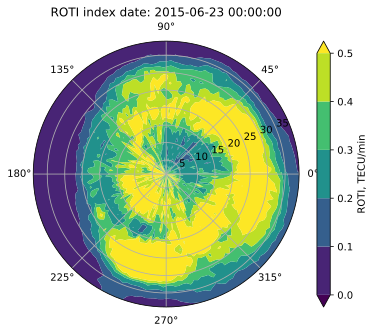

1999


In [9]:
# example of ROTI map

# doy = ["020", "021", "022", "023", "024"]
doy = ["174"]
all_maps = []

for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)

for i in range(len(roti_map_date)):
    if roti_map_date[i][0] == 23 and roti_map_date[i][1] == 6 and roti_map_date[i][2] == 2015:
        print(i)
        break



В каждой карте ROTI 3600 вещественных чисел. Нейронной сети сложно предсказать сразу все числа, имея только 29 параметров. Сократим эти данные, взяв среднее по фиксированному числу элементов в каждом массиве.

In [31]:
def roti_encode(roti_maps, less_num):
    new_roti_maps = []
    for i in range(len(roti_maps)):
        j = 0
        new_roti_map = []
        while j < len(roti_maps[i]):
            numbers_roti = []
            for item in range(less_num):
                numbers_roti.append(roti_maps[i][j + item])
            j += less_num
            numbers_roti = np.array(numbers_roti)
            new_roti_map.append(np.mean(numbers_roti))
        new_roti_maps.append(new_roti_map)
    return np.array(new_roti_maps)

def roti_decode(roti_maps, less_num):
    new_roti_maps = []
    for i in range(len(roti_maps)):
        j = 0
        new_roti_map = []
        while j < len(roti_maps[i]):
            for num in range(less_num):
                new_roti_map.append(roti_maps[i][j])
            j += 1
        new_roti_maps.append(new_roti_map)
    return np.array(new_roti_maps)

new_roti_maps = roti_encode(roti_maps_reshape, 5)
new_roti_maps.shape

(3277, 720)

Всего данных - 3935. Будем использовать 92% данных для тренировки сети, 4% для валидации и оставшиеся 4% для теста:
```
- train_data - 3635
- val_data - 150
- test_data - 150
```

Также необходимо провести нормировку всех данных, кроме карт ROTI, поскольку они уже изначально имеют значения в диапазоне (0;1)

In [81]:
# Normalize data
train_num = 3000

def mean_data(data):
    mean = data[:train_num].mean(axis=0)
    data -= mean
    std = data[:train_num].std(axis=0)
    data /= std
    return data

# kp_data = mean_data(kp_arr)
# bz_data = mean_data(bz_arr)
# f107_data = mean_data(f107_arr)
# dst_data = mean_data(dst_arr)
# sw_data = mean_data(sw_arr)
all_indexes = mean_data(data_all_arr)

Соберем данные индексов в единый массив со следующей индексацией:
- 0 : KP index
- 1 : BZ index
- 2 : SW Proton Density
- 3 : SW Plasma Speed
- 4 : F10-7
- 5-28 : DST index

In [12]:
def accumulate_indexes(kp_data, bz_data, sw_data, f107_data, dst_data):
    all_indexes = []
    for i in range(len(kp_data)):
        indexes = []
        # indexes.append(kp_data[i][0])
        indexes.append(bz_data[i][0])
        # indexes.append(sw_data[i][0])
        # indexes.append(sw_data[i][1])
        indexes.append(f107_data[i][0])
        # for j in range(24):
        #     indexes.append(dst_data[i][j])
        all_indexes.append(indexes)
    return np.array(all_indexes)

all_indexes = []
all_indexes = accumulate_indexes(kp_data, bz_data, sw_data, f107_data, dst_data)
all_indexes.shape

(3935, 2)

In [14]:
# for day in doy:
#     filename = '../data/roti/2010-2020/roti' + day + '0.15f'

#     lats = []
#     rows = []
#     date_map = []

#     date, lats, date_map, map = read_roti(filename)

#     all_maps.append(map)
#     all_map = np.mean(all_maps, axis=0)
#     # print("all_map:\n", all_map.shape[1])
#     lons = np.linspace(1, 361, all_map.shape[1])
#     # lons = np.linspace(1, 361, 180)
#     plot_data_roti(date, lons, lats, map)
#     map_data = []
#     for i in range(len(new_roti_maps[1999])):
#         map_data.append(new_roti_maps[1999][i])
#     map_data = np.array(map_data)
#     map_data = map_data.reshape(1, 720)
#     map = roti_decode(map_data, less_num=5)
#     map = map.reshape(20, 180)
#     plot_data_roti(date, lons, lats, map)

- 3935 данных не достаточно для успешной тренировки, поэтому увеличим данные за счет добавки шума к индексам, а целевые данные карт оставим для этих данных такой же. Так мы увеличим *dataset* и улучшим стабильность нейросети. Увелим набор данных в 3 раза, то есть теперь данных будет 11805

- Из 11805 данных 80% выделим для train, а по 10% на val и test:
```
train - 9445
val - 1180
test - 1180
```

In [82]:
# Define class to add andom noise for data (Ornstein–Uhlenbeck process)

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.0015, dt=1e-4, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_init = x_initial
        self.reset()
    
    def __call__(self):
        # Formula is taken from https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
        x = (
            self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev + np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_init is not None:
            self.x_prev = self.x_init
        else:
            self.x_prev = np.zeros_like(self.mean)

In [83]:
# function for increasing trainig data

std_dev = 0.001
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
# noise = ou_noise()
# print(noise)

def increse_data(new_roti_maps, all_indexes):
    big_indexes = []
    big_roti = []
    for i in range(len(all_indexes)):
        noise_arr = []
        for j in range(len(all_indexes[i])):
            noise = float(ou_noise())
            noise_arr.append(noise)
        noise = np.array(noise_arr)
        big_indexes.append(all_indexes[i] - noise)
        big_roti.append(new_roti_maps[i])
        big_indexes.append(all_indexes[i])
        big_roti.append(new_roti_maps[i])
        big_indexes.append(all_indexes[i] + noise)
        big_roti.append(new_roti_maps[i])
    return np.array(big_indexes), np.array(big_roti)

big_indexes, big_roti = increse_data(new_roti_maps, all_indexes)

print(big_roti.shape)
print(big_indexes.shape)

(9831, 720)
(9831, 13)


Для упрощения целевых значений, сделаем "срез" в данных карт ROTI - если величина в карте > 0.6, то мы приравнивам ее к 0.7

In [17]:
# def change_roti(big_roti):
#     for i in range(len(big_roti)):
#         for j in range(len(big_roti[i])):
#             if big_roti[i][j] > 0.6:
#                 big_roti[i][j] = 0.7
#     return big_roti

# big_roti = change_roti(big_roti)
# big_roti

##### Generation sample-targets lists function
- **data_indexes** — исходный массив вещественных чисел - *all_indexes*
- **roti_data** - преобразованный массив карт ROTI, который будет исполльзоваться в качестве целевых данных - *roti_maps_reshape*
- **lookback** — количество интервалов в прошлом от заданного момента, за которое отбираются входные данные - 3 дня
- **delay** — количество интервалов в будущем от заданного момента, за которое отбираются целевые данные - 1 день. Данный параметр применяется к картам ROTI
- **min_index** и **max_index** — индексы в массиве data, ограничивающие область для извлечения данных; это помогает оставить в неприкосновенности сегменты проверочных и контрольных данных
- **shuffle** — флаг, определяющий порядок извлечения образцов: с перемешиванием или в хронологическом порядке
- **batch_size** — количество образцов в пакете - 32
- **step** — период в интервалах, из которого извлекается один образец - 1

In [84]:
# Generation sample-targets lists function

def generator(data_indexes, roti_data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=1):
    if max_index is None:
        max_index = len(data_indexes) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data_indexes.shape[-1]))
        targets = np.zeros((len(rows), len(roti_data[0])))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data_indexes[indices]
            for item in range(len(roti_data[0])):
                targets[j][item] = roti_data[rows[j] + delay][item]
        # targets = roti_data[i + delay]
        # targets = targets.reshape(20, 180)
        yield samples, targets

# min_index = 0
# lookback = 0
# max_index = 5
# batch_size = 1
# delay = 1
# step = 1

# rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
# samples = np.zeros((len(rows), lookback // step, kp_data.shape[-1]))
# targets = np.zeros((len(rows), len(new_roti_maps[0])))
# for j, row in enumerate(rows):
#     indices = range(rows[j] - lookback, rows[j], step)
#     samples[j] = kp_data[indices]
#     for item in range(len(new_roti_maps[0])):
#         targets[j][item] = new_roti_maps[rows[j] + delay][item]
#     print(new_roti_maps[rows[j] + delay].shape)
# targets.shape

In [85]:
lookback = 2
step = 1
delay = 1
batch_size = 32

# all_indexes = big_indexes
# new_roti_maps = big_roti

all_data_num = all_indexes.shape[0]
min_index_train = 0
max_index_train = int(all_data_num * 0.8)
min_index_val = int(max_index_train + 1)
max_index_val = int(max_index_train + int(all_data_num * 0.1))
min_index_test = int(max_index_val + 1)
max_index_test = None


train_gen = generator(big_indexes,
 big_roti,
 lookback=lookback,
 delay=delay,
 min_index=min_index_train,
 max_index=max_index_train,
 shuffle=True,
 step=step,
 batch_size=batch_size)
val_gen = generator(big_indexes,
 big_roti,
 lookback=lookback,
 delay=delay,
 min_index=min_index_val,
 max_index=max_index_val,
 step=step,
 batch_size=batch_size)
test_gen = generator(big_indexes,
 big_roti,
 lookback=lookback,
 delay=delay,
 min_index=min_index_test,
 max_index=max_index_test,
 step=step,
 batch_size=batch_size)

# Сколько раз нужно обратиться к val_gen, чтобы получить проверочный набор данных целиком
val_steps = (max_index_val - min_index_val - lookback) // batch_size

# Сколько раз нужно обратиться к test_gen gen, чтобы получить контрольный набор данных целиком
test_steps = (len(all_indexes) - min_index_test - lookback) // batch_size


In [86]:
from keras.models import Sequential, model_from_json
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [87]:

weights_file = 'W_LSTM_LSTM_test_1.h5'

callback = ModelCheckpoint(weights_file, mode='max', save_best_only=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.75)

model = Sequential()
model.add(layers.LSTM(256,
 dropout=0.1,
 recurrent_dropout=0.3,
 kernel_regularizer=regularizers.L1(1e-4),
 return_sequences=True,
 input_shape=(None, big_indexes.shape[-1])))
# model.add(layers.LSTM(128,
#  dropout=0.2,
#  recurrent_dropout=0.4,
#  kernel_regularizer=regularizers.L1(0.001),
#  return_sequences=True,))
model.add(layers.LSTM(512,
 dropout=0.2,
 recurrent_dropout=0.4,
 kernel_regularizer=regularizers.L1(0.001),))
# model.add(layers.Dense(500, kernel_regularizer=regularizers.L1(l1=0.005), activation='softmax'))
# model.add(layers.Dense(500, kernel_regularizer=regularizers.L1(l1=0.005), activation='relu'))
# model.add(layers.Dense(1500, kernel_regularizer=regularizers.L1(l1=0.01), activation='relu'))
model.add(layers.Dense(720))
model.summary()
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse')

# with open("model.json", 'r') as f:
#     model = model_from_json(f.read)

# model.load_weights('W_LSTM_LSTM_dc_12.h5')

history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=10,
 validation_data=val_gen,
 validation_steps=val_steps,
 callbacks=[callback])

json_file = 'M_LSTM_LSTM_test_01.json'
model_json = model.to_json()
with open(json_file, 'w') as f:
    f.write(model_json)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         276480    
                                                                 
 lstm_1 (LSTM)               (None, 512)               1574912   
                                                                 
 dense (Dense)               (None, 720)               369360    
                                                                 
Total params: 2,220,752
Trainable params: 2,220,752
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-11-24 15:26:57.902443: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


500/500 [==============================] - 14s 23ms/step - loss: 0.5869 - val_loss: 0.0752
Epoch 2/10
500/500 [==============================] - 13s 26ms/step - loss: 0.0755 - val_loss: 0.0699
Epoch 3/10
500/500 [==============================] - 14s 27ms/step - loss: 0.0714 - val_loss: 0.0666
Epoch 4/10
500/500 [==============================] - 14s 27ms/step - loss: 0.0670 - val_loss: 0.0615
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 0.0634 - val_loss: 0.0582
Epoch 6/10
500/500 [==============================] - 13s 27ms/step - loss: 0.0595 - val_loss: 0.0551
Epoch 7/10
500/500 [==============================] - 14s 27ms/step - loss: 0.0567 - val_loss: 0.0520
Epoch 8/10
500/500 [==============================] - 13s 27ms/step - loss: 0.0539 - val_loss: 0.0497
Epoch 9/10
500/500 [==============================] - 13s 26ms/step - loss: 0.0515 - val_loss: 0.0471
Epoch 10/10
500/500 [==============================] - 13s 27ms/step - loss: 0.0491 - val_los

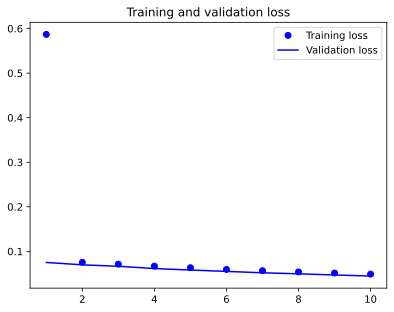

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.ylim(0, 0.3)
plt.legend()
plt.show()

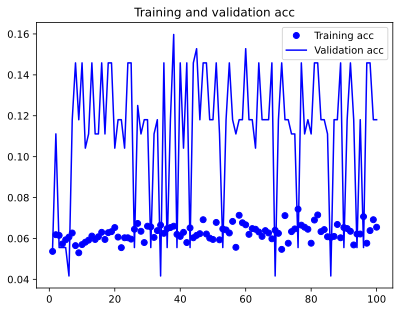

In [31]:
# loss = history.history['acc']
# val_loss = history.history['val_acc']
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training acc')
# plt.plot(epochs, val_loss, 'b', label='Validation acc')
# plt.title('Training and validation acc')
# plt.legend()
# plt.show()

In [89]:
print("Evaluate on test data")
results = model.evaluate_generator(test_gen, steps=test_steps)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: 0.06087062880396843


1/1 [==============================] - 0s 16ms/step
predictions shape: (1, 720)


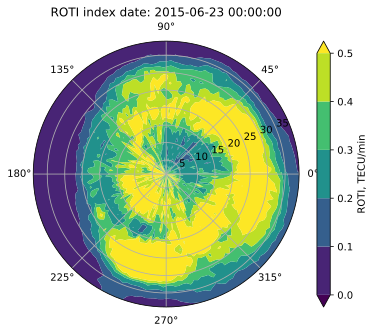

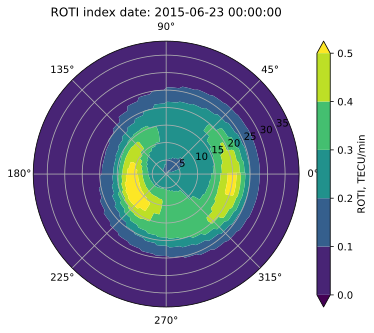

In [94]:
predict = generator(all_indexes,
 new_roti_maps,
 lookback=2,
 delay=1,
 min_index=1995,
 max_index=1998,
 step=1,
 batch_size=1)

predictions = model.predict(predict, steps=1)
print("predictions shape:", predictions.shape)
# print("predictions:", predictions)
doy = ["174"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = roti_decode(predictions, less_num=5)
    map = map.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

1/1 [==============================] - 0s 17ms/step
predictions shape: (1, 720)


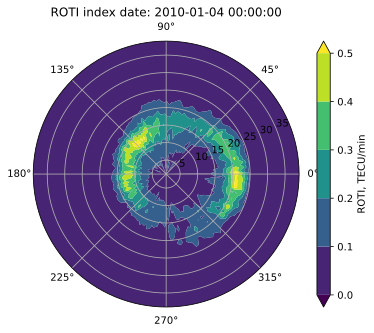

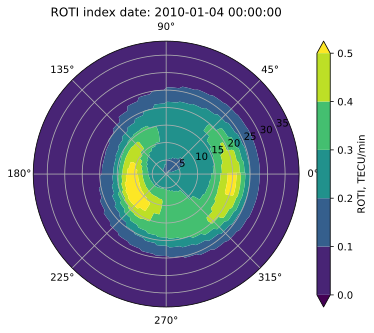

In [95]:
predict = generator(all_indexes,
 new_roti_maps,
 lookback=2,
 delay=1,
 min_index=0,
 max_index=3,
 step=1,
 batch_size=1)

predictions = model.predict(predict, steps=1)
print("predictions shape:", predictions.shape)
# print("predictions:", predictions)
doy = ["004"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.10f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = roti_decode(predictions, less_num=5)
    map = map.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

1/1 [==============================] - 0s 17ms/step
predictions shape: (1, 720)


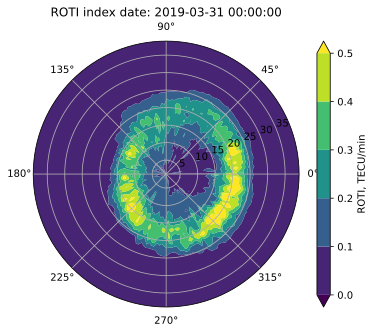

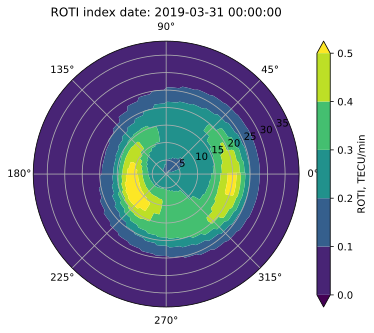

In [98]:
predict = generator(all_indexes,
 new_roti_maps,
 lookback=2,
 delay=1,
 min_index=3273,
 max_index=3276,
 step=1,
 batch_size=1)

predictions = model.predict(predict, steps=1)
print("predictions shape:", predictions.shape)
# print("predictions:", predictions)
doy = ["090"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.19f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = roti_decode(predictions, less_num=5)
    map = map.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

## Задачи
- Слишком много данных с низким индексом и мало с высоким => переобучение на малые индексы => модель усредняет предсказания
- Добавить lookback на 27 дней назад (то есть 2-3 дня + 1 день 27 дней назад) +
- Добавить в данные также предыдущую карту ROTI
- min по imf-bz в день помимо среднесуточных +
- 27 дневная медиана для f107 +
- добавить AE, AU, AL, AO (независимые - AU, AL; производные - AE, AO) +
- тест на разных архитектурах
- кроссзависимую таблицу по индексам (корреляция по индексам)